# Bird Sound Recognize

## Value Setting

### Mount at Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### Train Value

In [2]:
SOUND_PATH = r"/content/gdrive/MyDrive/Bird_sound/dataset/raw"
DATASET_PATH = r"/content/gdrive/MyDrive/Bird_sound/dataset/Tyler_data"
WAV_PATH = r""

MODEL_NAME = "Model_500Epochs_v3"

TIME_STEP = 20
SOUND_LENGTH = 128
TEST_DATA_RATIO = 0.2
INPUT_SHAPE = (TIME_STEP, SOUND_LENGTH)
CLASSES = ["before_net", "build_net", "fail", "hug_egg", "out_net", "spawn", "yu_zhu_gi"]

MODEL_CONV1DS = [32, 32]
MODEL_LAYERS = [64, 128, 0, 32, 64]

BATCH_SIZE = 50
EPOCHS = 100

## Prepare All Tool

### Prepare Package

In [3]:
%tensorflow_version 1.x
import os
import random
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPool1D, Flatten, Dropout
from tensorflow.keras.layers import Input, TimeDistributed, Dense
from tensorflow.keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
import json
import librosa
import random
import pickle

TensorFlow 1.x selected.


### Sound Proccess Tool

In [4]:
class SoundProcessor:
    def __init__(self):
        self.data = []
        self.sr = None

    def load_sound(self, path):
        self.data, self.sr = librosa.load(path)
        return self.data

    def transform_mfcc(self, data):
        mfcc = librosa.feature.mfcc(y=data, sr=self.sr, n_mfcc=SOUND_LENGTH)
        arr = mfcc.T
        arr = arr[np.shape(arr)[0] % TIME_STEP:, :]
        return arr

    def bird_sound_all_classes_json(self, load_folder, save_path):
        if not os.path.exists(save_path):
            os.mkdir(save_path)
        for folder in os.listdir(load_folder):
            load_path = os.path.join(load_folder, folder)
            folderData = []
            for filename in os.listdir(os.path.join(load_path)):
                data = self.load_sound(os.path.join(load_path, filename))
                mfccArr = self.transform_mfcc(data)
                if mfccArr.shape[0] < TIME_STEP:
                    print(filename, "arr is too short, ignored.", mfccArr.shape)
                    continue
                for subArr in np.split(mfccArr, mfccArr.shape[0] // TIME_STEP):
                    # print("test")
                    # print(len(subArr[0]))
                    folderData.append(subArr.tolist())
                print(filename, " done.")
            split_idx = max(1, int(len(folderData) * TEST_DATA_RATIO))
            random.shuffle(folderData)
            test_arr = folderData[:split_idx]
            train_arr = folderData[split_idx:]
            # print(test_arr)
            # print(train_arr)
            filename = os.path.join(save_path, folder + ".json")
            with open(filename, "w") as f:
                print(np.array(test_arr).shape)
                print(np.array(train_arr).shape)
                data = {"test": test_arr, "train": train_arr}
                json.dump(data, f)
            print(folder + ".json", " saved.  \n", "Located: ", filename)

        print("Every folder have done!")
        print(f"Save at path: {save_path}")
        print("==================================================================================================")

    def bird_sound_all_classes_npy(self, load_folder, save_path):
        if not os.path.exists(save_path):
            os.mkdir(save_path)
        for folder in os.listdir(load_folder):
            load_path = os.path.join(load_folder, folder)
            folderData = []
            for filename in os.listdir(os.path.join(load_path)):
                data = self.load_sound(os.path.join(load_path, filename))
                mfccArr = self.transform_mfcc(data)
                if mfccArr.shape[0] < TIME_STEP:
                    print(filename, "arr is too short, ignored.", mfccArr.shape)
                    continue
                for subArr in np.split(mfccArr, mfccArr.shape[0] // TIME_STEP):
                    folderData.append(subArr)
                print(filename, " done.")
            split_idx = max(1, int(len(folderData) * TEST_DATA_RATIO))
            test_arr = folderData[:split_idx]
            train_arr = folderData[split_idx:]
            random.shuffle(folderData)
            test_npy_folder = os.path.join(save_path, "test")
            train_npy_folder = os.path.join(save_path, "train")
            if not os.path.exists(test_npy_folder):
                os.mkdir(test_npy_folder)
            if not os.path.exists(train_npy_folder):
                os.mkdir(train_npy_folder)
            test_npy_filename = os.path.join(test_npy_folder, folder + ".npy")
            train_npy_filename = os.path.join(train_npy_folder, folder + ".npy")
            np.save(test_npy_filename, np.asarray(test_arr))
            # print(test_arr)
            np.save(train_npy_filename, np.asarray(train_arr))
            print(test_npy_filename, "saved. length:", TIME_STEP, " x ", SOUND_LENGTH)
            print(train_npy_filename, "saved. length:", TIME_STEP, " x ", SOUND_LENGTH)

        print("Every folder have done!")
        print(f"Save at path: {save_path}")
        print("==================================================================================================")

    def instant_transform(self, data):
        mfccArr = self.transform_mfcc(data)
        if mfccArr.shape[0] < TIME_STEP:
            print("Video is too short, can't recognize.")
            return np.array([])
        queue = [subArr for subArr in np.split(mfccArr, mfccArr.shape[0] // TIME_STEP)]
        return np.array(queue)

    def load_json(self, load_folder):
        x_train = []
        y_train = []
        x_test = []
        y_test = []
        for y, filename in enumerate(os.listdir(os.path.join(load_folder, "JSON"))):
            load_path = os.path.join(load_folder, "JSON", filename)
            print(load_path)
            data = json.load(open(load_path))
            print(f"{filename} have loaded.")
            x_test += data["test"]
            x_train += data["train"]
            for i in range(len(data["test"])):
                y_test.append(y)
            for i in range(len(data["train"])):
                y_train.append(y)

        return np.array(x_train), np.array(y_train), np.array(x_test), np.array(y_test)

    def load_npy(self, load_folder):
        x_train = []
        y_train = []
        x_test = []
        y_test = []
        for y, filename in enumerate(os.listdir(os.path.join(load_folder, "NPY", "train"))):
            load_path = os.path.join(load_folder, "NPY", "train", filename)
            print(load_path)
            data = np.load(load_path, allow_pickle=True)
            print(f"{filename} have loaded, shape: ", data.shape)
            x_train += data.tolist()
            for i in range(data.shape[0]):
                y_train.append(y)

        for y, filename in enumerate(os.listdir(os.path.join(load_folder, "NPY", "test"))):
            load_path = os.path.join(load_folder, "NPY", "test", filename)
            print(load_path)
            data = np.load(load_path, allow_pickle=True)
            print(f"{filename} have loaded, shape: ", data.shape)
            x_test += data.tolist()
            for i in range(data.shape[0]):
                y_test.append(y)
        return np.array(x_train), np.array(y_train), np.array(x_test), np.array(y_test)


### Model Create Tool

#### Classes TransForm

In [5]:
def classes_change(mode):
    for i, C in enumerate(CLASSES):
        if i == mode:
            return C
    return "None"

#### Create Model

In [6]:
def createConv1DModel(
        name,
        n_conv1Ds,
        n_layers,
        d_input,
        n_classes):
    """
    @param name: model name
    @param n_conv1Ds: filters of conv1D
    @param n_layers: filters of dense
    @param d_input: input shape
    @param n_classes: output classes
    @return: model
    """

    model = Sequential(name=f"{name}")
    model.add(Conv1D(128, kernel_size=3, input_shape=d_input, activation="relu"))
    model.add(MaxPool1D(pool_size=2))
    for i in n_conv1Ds[1:]:
        if i == 0:
            model.add(Dropout(0.2))
        else:
            model.add(Conv1D(i, kernel_size=3, activation="relu"))
            model.add(MaxPool1D(pool_size=2))
    model.add(Flatten())
    for i in n_layers:
        if i == 0:
            model.add(Dropout(0.2))
        else:
            model.add(Dense(i, activation="relu"))
    model.add(Dense(len(n_classes), activation="softmax"))
    model.summary()
    return model


#### Get Model

In [7]:
def get_model():
    return createConv1DModel("model",
                  MODEL_CONV1DS,
                  MODEL_LAYERS,
                  INPUT_SHAPE,
                  CLASSES,
                  )


#### Model Basic Functions

In [8]:
def setting(model):
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def fit(model, x_train, y_train, x_test, y_test, batch, epochs):
    y_train = to_categorical(y_train, 7)
    y_test = to_categorical(y_test, 7)
    print("START TRAINING==================================================================")
    train_history = model.fit(x=x_train, y=y_train,
                              validation_split=0.2,
                              epochs=epochs,
                              batch_size=batch,
                              verbose=2,
                              validation_data=(x_test, y_test),
                              shuffle=True,
                              )
    return model, train_history

def save(model, save_path, name):
    if not os.path.exists(save_path):
        os.mkdir(save_path)
    model.save(os.path.join(save_path, name+".h5"))
    print("Model have saved.")

def load(save_path):
    model = keras.models.load_model(save_path+".h5")
    model.summary()
    return model


#### Predict Function

In [9]:
def predict_classes(model, data):
    prediction = [np.argmax(arr) for arr in model.predict(data)]
    predict_class = [classes_change(arr) for arr in prediction]
    return prediction, predict_class


#### Test Function

In [10]:

def test(model, x_test, y_test, test_time=10):
    success = 0
    predictions, classes = predict_classes(model, x_test)
    for i in range(test_time):
        index = random.randint(0, len(x_test))
        predict = predictions[index]
        print(f"test{i+1}\t| prediction: ", classes[index], "\n     \t| answer: ", classes_change(y_test[index]))
        if predict == y_test[index]:
            print(f"Match\t| [ O ]")
            success += 1
        else:
            print(f"Match\t| [ X ]")
    print("Accuracy: ", success/test_time, "%.")


#### Plot Model's Accuracy & Loss

In [11]:
def load_history(load_path, name):
    with open(os.path.join(load_path, name+"_history.p"), 'rb') as f:
        history = pickle.load(f)
    print("History have loaded")
    return history


def save_history(history, save_path, name):
  history = history.history
  if not os.path.exists(save_path):
    os.mkdir(save_path)
  with open(os.path.join(save_path, name+"_history.p"), 'wb') as f:
      pickle.dump(history, f)
  print("History have saved")


def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name, is_save=True, save_path=""):
    '''
    This function will plot the metrics passed to it in a graph.
    Args:
        model_training_history: A history object containing a record of training and validation
                                loss values and metrics values at successive epochs
        metric_name_1:          The name of the first metric that needs to be plotted in the graph.
        metric_name_2:          The name of the second metric that needs to be plotted in the graph.
        plot_name:              The title of the graph.
    '''

    # Get metric values using metric names as identifiers.
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]

    # Construct a range object which will be used as x-axis (horizontal plane) of the graph.
    epochs = range(len(metric_value_1))
    # Plot the Graph.
    fig = plt.figure()
    plt.plot(epochs, metric_value_1, 'blue', label=metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label=metric_name_2)

    # Add title to the plot.
    plt.title(str(plot_name))

    # Add legend to the plot.
    plt.legend()
    plt.show()
    if not os.path.exists(save_path) and is_save:
      os.mkdir(save_path)

    if is_save and save_path != "":
      fig.savefig(save_path+".png")

def plot_all(model_training_history):
  plot_metric(model_training_history, "loss", "val_loss", "Train Loss Vs Train Val Loss",
        True, os.path.join(DATASET_PATH, "MODEL", MODEL_NAME + "_loss"))
  plot_metric(model_training_history, "acc", "val_acc", "Train Acc Vs Train Val Acc",
        True, os.path.join(DATASET_PATH, "MODEL", MODEL_NAME + "_acc"))



In [12]:
def plot(history, save_path, name):
    if not os.path.exists(save_path):
        os.mkdir(save_path)
    print(history.history.keys())
    fig = plt.figure()
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    fig.savefig(os.path.join(save_path, f"{name}_accuracy.png"))

    fig = plt.figure()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    fig.savefig(os.path.join(save_path, f"{name}_loss.png"))


### Main wav proccess

In [13]:
def main_wav_process(mode):
    soundTool = SoundProcessor()
    if mode == "npy":
        soundTool.bird_sound_all_classes_npy(SOUND_PATH, os.path.join(DATASET_PATH, "NPY"))
    elif mode == "json":
        soundTool.bird_sound_all_classes_json(SOUND_PATH, os.path.join(DATASET_PATH, "JSON"))


### Data Loader

In [14]:
def data_loader(mode):
    soundTool = SoundProcessor()
    if mode == "npy":
        x_train, y_train, x_test, y_test = soundTool.load_npy(DATASET_PATH)
    elif mode == "json":
        x_train, y_train, x_test, y_test = soundTool.load_json(DATASET_PATH)
    else:
        print("Please choice data type.")
        return
    return x_train, y_train, x_test, y_test

### Main Training


In [15]:
def main_training(x_train, y_train, x_test, y_test):
    print("x_train: ", x_train.shape)
    print("y_train: ", y_train.shape)
    print("x_test: ", x_test.shape)
    print("y_test: ", y_test.shape)
    model = get_model()
    model = setting(model)
    model, history = fit(model,
                x_train, y_train,
                x_test, y_test,
                BATCH_SIZE,
                EPOCHS,
                )
    save(model, os.path.join(DATASET_PATH, "MODEL"), MODEL_NAME)
    return model, history


### Main Plot
 

In [16]:
def main_plot(history):
    plot_all(history)

### Main Testing

In [17]:
def main_testing(x_test, y_test):
    model = load(os.path.join(DATASET_PATH, "MODEL", MODEL_NAME))
    test(model, x_test, y_test, 150)

### Main Test wav


In [18]:
def main_test_wav(wav_path):
    model = load(os.path.join(DATASET_PATH, "MODEL", MODEL_NAME))
    soundTool = SoundProcessor()
    data = soundTool.load_sound(wav_path)
    mfccData = soundTool.instant_transform(data)
    if mfccData.shape[0] != np.array([]).shape[0]:
        predictions, classes = predict_classes(model, mfccData)
        print("Prediction: ", max(classes))

## Main

In [19]:
# main_wav_process("npy")
# main_wav_process("json")

In [20]:
x_train, y_train, x_test, y_test = data_loader("json")

/content/gdrive/MyDrive/Bird_sound/dataset/Tyler_data/JSON/before_net.json
before_net.json have loaded.
/content/gdrive/MyDrive/Bird_sound/dataset/Tyler_data/JSON/build_nest.json
build_nest.json have loaded.
/content/gdrive/MyDrive/Bird_sound/dataset/Tyler_data/JSON/fail.json
fail.json have loaded.
/content/gdrive/MyDrive/Bird_sound/dataset/Tyler_data/JSON/hug_egg.json
hug_egg.json have loaded.
/content/gdrive/MyDrive/Bird_sound/dataset/Tyler_data/JSON/out_nest.json
out_nest.json have loaded.
/content/gdrive/MyDrive/Bird_sound/dataset/Tyler_data/JSON/spawn.json
spawn.json have loaded.
/content/gdrive/MyDrive/Bird_sound/dataset/Tyler_data/JSON/yu_zhu_qi.json
yu_zhu_qi.json have loaded.


In [21]:
model, history = main_training(x_train, y_train, x_test, y_test)

x_train:  (8101, 20, 128)
y_train:  (8101,)
x_test:  (2021, 20, 128)
y_test:  (2021,)
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 18, 128)           49280     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 9, 128)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 7, 32)             12320     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 3, 32)             0         
_________________________________________________________________
flatten (Flatten)            (None, 96)                0         
_________________________________________________________________
dense (Dense)             

In [22]:
save_history(history, os.path.join(DATASET_PATH, "HISTORY"), MODEL_NAME)

History have saved


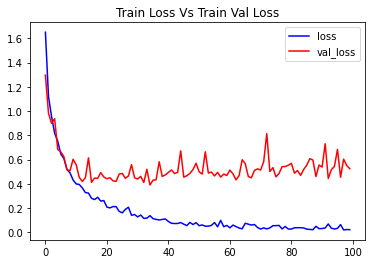

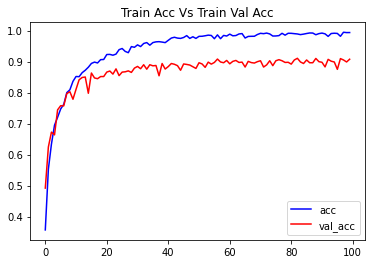

In [23]:
main_plot(history)

In [24]:
main_testing(x_test, y_test)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 18, 128)           49280     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 9, 128)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 7, 32)             12320     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 3, 32)             0         
_________________________________________________________________
flatten (Flatten)            (None, 96)                0         
_______________________

In [25]:
# main_test_wav(WAV_PATH)

## Debug


In [27]:
# !pip uninstall h5py -y
# !pip install h5py==2.10 -i https://pypi.tuna.tsinghua.edu.cn/simple/